In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt

# 1. 데이터 만들기 

In [2]:
# 데이터 불러오기
def load_all():
    train_activity = pd.read_csv('./train_activity.csv').drop('Unnamed: 0', axis=1)
    train_combat = pd.read_csv('./train_combat.csv')
    train_payment = pd.read_csv('./train_payment.csv')
    train_trade = pd.read_csv('./train_trade.csv')
    train_pledge = pd.read_csv('./train_pledge.csv')
    train_label = pd.read_csv('./train_label_add.csv')
    return train_activity, train_combat, train_payment, train_trade, train_pledge, train_label

In [3]:
train_activity, train_combat, train_payment, train_trade, train_pledge, train_label = load_all()

In [4]:
train_activity = train_activity[train_activity['server']!='bs']
train_activity = train_activity[train_activity['playtime']!=0]

In [34]:
act_combat = pd.merge(train_activity, train_combat, on =['acc_id','char_id','day','server'], how='outer')

In [35]:
# 3. 전체  - 주캐  (나누는 건 더 나쁨) 안 빼고 그냥 주캐 시간만 추가하는 게 제일 나음
# 전반적으로 주캐 값만 쓰는 게 더 낫지만 엎치락 뒤치락 하는 경우도 있음

# 1) activity에 combat에 없는 서버 활동 지우고 합치기
com_act = pd.merge(train_combat, train_activity, on=['acc_id','char_id','day'], how='inner')
com_act_40000 = com_act.groupby('acc_id').sum().reset_index()
# 2) 레벨로 나누기
## 사용자 별로 레벨 최고인 캐릭터의 활동데이터 선정하는 컬럼 뽑기

# 2) 주캐와 부캐로 나눠서 sum (부캐가 없으면? =1)
com_act2 = com_act.groupby('acc_id')['level'].max().reset_index()
column = com_act[['acc_id','level','pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change',
       'enchant_count']]
com_act3 = pd.merge(com_act2,column, on=['acc_id','level'], how ='inner')
com_act3 = com_act3.groupby('acc_id').sum().reset_index()
act_40000_max = pd.merge(com_act_40000, com_act3, on=['acc_id'])

## 상관관계 잘 나왔던 주케와 전체 특성을 선별해서 분석해보겠습니다.

party_exp, private_shop, level, temp는 전체 캐릭터 

In [36]:
act_40000_best = act_40000_max[['acc_id', 'day', 'char_id', 'class', 'temp_cnt_x', 'private_shop_x', 
                               'level_x', 'party_exp_x', 'pledge_cnt_y', 'random_attacker_cnt_y', 'random_defender_cnt_y',
       'same_pledge_cnt_y', 'etc_cnt_y', 'num_opponent_y',
       'playtime_y', 'npc_kill_y', 'solo_exp_y', 'quest_exp_y',
       'rich_monster_y', 'death_y', 'revive_y', 'exp_recovery_y', 'fishing_y',
       'game_money_change_y', 'enchant_count_y']]

act_40000_best.columns = ['acc_id', 'day', 'char_id', 'class', 'temp_cnt', 'private_shop', 
                               'level', 'party_exp', 'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent',
       'playtime', 'npc_kill', 'solo_exp', 'quest_exp',
       'rich_monster', 'death', 'revive', 'exp_recovery', 'fishing',
       'game_money_change', 'enchant_count']

In [37]:
# 7. 생존과 부활 비교
act_40000_best['forgive'] = act_40000_best['death'] - act_40000_best['revive']

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [38]:
com_act = pd.merge(train_combat, train_activity, on=['acc_id','char_id','day'], how='inner').drop(['server_x','server_y'],axis=1)
feature_count = com_act.groupby(['acc_id','day']).sum().reset_index()
for col in ['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime',
       'npc_kill', 'solo_exp', 'party_exp', 'quest_exp', 'rich_monster',
       'death', 'revive', 'exp_recovery', 'fishing', 'private_shop',
       'game_money_change', 'enchant_count']:
    col_count = col + '_count'
    feature_count[col_count] = 0
for col in ['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime',
       'npc_kill', 'solo_exp', 'party_exp', 'quest_exp', 'rich_monster',
       'death', 'revive', 'exp_recovery', 'fishing', 'private_shop',
       'game_money_change', 'enchant_count']:
    col_count = col + '_count'
    feature_count[col_count] = np.where(feature_count[col]!=0,1,0)
    
feature_count = feature_count.groupby('acc_id').sum().reset_index().drop(['day', 'char_id', 'class', 'level', 'pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change'], axis=1)

In [39]:
  act_40000_best = pd.merge(act_40000_best, feature_count, on ='acc_id')

In [40]:
act_40000_best.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 47 columns):
acc_id                       40000 non-null int64
day                          40000 non-null int64
char_id                      40000 non-null int64
class                        40000 non-null int64
temp_cnt                     40000 non-null float64
private_shop                 40000 non-null float64
level                        40000 non-null int64
party_exp                    40000 non-null float64
pledge_cnt                   40000 non-null float64
random_attacker_cnt          40000 non-null float64
random_defender_cnt          40000 non-null float64
same_pledge_cnt              40000 non-null float64
etc_cnt                      40000 non-null float64
num_opponent                 40000 non-null float64
playtime                     40000 non-null float64
npc_kill                     40000 non-null float64
solo_exp                     40000 non-null float64
quest_exp        

In [41]:
# 9. 접속 중단 횟수

# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()
# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(40000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id.groupby('acc_id').sum().reset_index()
acc_id = acc_id['acc_id']
acc_id = acc_id.values

# day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,40000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

# 만든 데이터프레임에 실제 접속일 데이터 merge
stop_count_df = pd.merge(day_df, real_day,  on=['acc_id','day'],how='outer')
# 접속하지 않은 날은 0, 접속일은 1로 표시
stop_count_df['login'] = np.where(stop_count_df['playtime'].isnull(), 0, 1)
stop_count_df['stop'] = 0
#stop_count_df['day'] = np.where(stop_count_df['playtime'].isnull(), 0, stop_count_df['day'])
# 이제 필요 없는 playtime 제거

stop_count_df = stop_count_df.drop('playtime',axis=1)

In [42]:
stop_count_np = stop_count_df.values

for i in range(0,len(stop_count_df)-1):
    if stop_count_np[i+1][2] - stop_count_np[i][2] == 1:
        stop_count_np[i+1][3] = 1
#for i in range(0,40000):
#    if stop_count_np[i*28][2] == 0:
#        stop_count_np[i*28][3] = -1
stop_count_df = DataFrame(stop_count_np, columns = ['acc_id', 'day', 'login', 'stop'])

In [43]:
stop_count_40000 = stop_count_df.groupby('acc_id').sum().reset_index()

In [44]:
stop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
acc_id    40000 non-null float64
stop      40000 non-null float64
dtypes: float64(2)
memory usage: 625.1 KB


In [45]:
stop = stop_count_40000[['acc_id','stop']]
act_40000_best = pd.merge(act_40000_best, stop, on= 'acc_id')

### 여기서부터 추가하는 변수는 전체 캐릭터를 대상으로 했습니다

In [309]:
data1 = act_combat.drop(['char_id', 'server', 'class','level', 'day'],axis=1)

In [310]:
# 모든 변수는 40000행 데이터셋에 맞춰서 merge 됩니다. 
def std(x): return np.std(x)


def num_combat(train_combat, data):
    num_combat = train_combat[['acc_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    # 전투기록이 있으면 1, 아니면 0
    num_combat['pledge_cnt'] = np.where(train_combat['pledge_cnt']>0, 1,0)
    num_combat['random_attacker_cnt'] = np.where(train_combat['random_attacker_cnt']>0, 1,0)
    num_combat['random_defender_cnt'] = np.where(train_combat['random_defender_cnt']>0, 1,0)
    num_combat['temp_cnt'] = np.where(train_combat['temp_cnt']>0, 1,0)
    num_combat['same_pledge_cnt'] = np.where(train_combat['same_pledge_cnt']>0, 1,0)
    num_combat['etc_cnt'] = np.where(train_combat['etc_cnt']>0, 1,0)

    # 합산 및 컬럼명 변경
    num_combat = num_combat.groupby('acc_id').sum().reset_index()

    num_combat.rename(columns={'pledge_cnt':'day_pledge', 'random_attacker_cnt':'day_attack', 'random_defender_cnt':'day_defend', 
                           'temp_cnt':'day_temp', 'same_pledge_cnt':'day_same', 'etc_cnt':'day_etc'},inplace=True)
    data2 = pd.merge(data, num_combat, on = 'acc_id')
    return data2

# 6. 레벨이 올랐는가?
# 의문점: 고렙 유저와 저렙 유저에 차이가 있어서 가중치를 줘야하나?
def deff_level(train_combat,data):    
    # 관련 컬럼 불러오기
    level =  train_combat[['acc_id','char_id','day','level']]
    # 캐릭터별 max 레벨과 min 레벨 생성
    level_max = level.groupby(['acc_id','char_id']).max().reset_index()
    level_min = level.groupby(['acc_id','char_id']).min().reset_index()
    # 레벨 데이터를  acc_id,char_id 단위 그룹으로 재정의(day 압축)
    level = level.groupby(['acc_id','char_id']).sum().reset_index()
    # max, min 컬럼 추가
    level['max'] = level_max['level']
    level['min'] = level_min['level']
    # 차이 계산
    level['deff_level'] = level['max'] - level['min']
    # acc_id로 그룹화 후, 필요 없는 컬럼 제거
    level = level.groupby(['acc_id']).sum().reset_index().drop(['max','min','day','level','char_id'],axis=1)
    # deff_level 추가
    data2 = pd.merge(data, level, on = 'acc_id')
    return data2

# 5. 캐릭터별 각 전투 변수의 28일 간 표준편차 (접속한 날만 대상으로 표준편차 구함)
def std_combat(train_combat,data):
    std_combat = train_combat[['acc_id','day','char_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    # 케릭터 별로 28일의 표준편차 구하고, day 없애고, 모든 값이 0이고 1행인 애들이 NaN이 나옴
    # 1안: 접속 안한 날은 전투시간 =0인 날로 간주하고 n=28로 분산 계산한다
    # 2안: 접속일수를 분모로 분산을 계산한다.
    # 3안: 유저 단위로 합쳐서 1,2안 중 하나를 계산한다
    # 4안: 다 해본다.
    
    std_combat = std_combat.groupby(['acc_id','char_id']).agg(std).reset_index().drop('day',axis=1).fillna(0)
    std_combat.rename(columns={'pledge_cnt':'std_pledge', 'random_attacker_cnt':'std_attack', 'random_defender_cnt':'std_defend', 
                           'temp_cnt':'std_temp', 'same_pledge_cnt':'std_same', 'etc_cnt':'std_etc'},inplace=True)
    
    # 일단 캐릭터별 표준편차를 유저 단위로 합함
    std_combat = std_combat.groupby('acc_id').sum().reset_index().drop('char_id',axis=1)
    data2 = pd.merge(data, std_combat, on = ['acc_id'])
    return data2

# 유저별 각 전투 변수의 28일 간 표준편차(접속한 날만 대상으로 표준편차 구함)
def acc_std_combat(train_combat,data):
    acc_std_combat = train_combat[['acc_id','day','char_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    
    acc_std_combat = acc_std_combat.groupby(['acc_id']).agg(std).reset_index().drop('day',axis=1).fillna(0)
    acc_std_combat.rename(columns={'pledge_cnt':'acc_std_pledge', 'random_attacker_cnt':'acc_std_attack', 'random_defender_cnt':'acc_std_defend', 
                           'temp_cnt':'acc_std_temp', 'same_pledge_cnt':'acc_std_same', 'etc_cnt':'acc_std_etc'},inplace=True)
    
    acc_std_combat = acc_std_combat.drop('char_id',axis=1)
    data2 = pd.merge(data, acc_std_combat, on = ['acc_id'])
    return data2


# 총 사용 캐릭터 개수(char_count), 총 접속일수(day_count)     
def char_day_count(train_combat,data):    
    char_count = train_combat.groupby(['day','acc_id'])['char_id'].count()
    char_count = char_count.reset_index()
    char_count = char_count.groupby('acc_id').count()
    char_count = char_count.reset_index()
    char_count.rename(columns={'day':'day_count','char_id':'char_count'},inplace=True)
    data2 = pd.merge(data, char_count, on = ['acc_id'])
    return data2

# 보유한 캐릭터 개수
def char_max(train_combat,data):
    char_max = train_combat.groupby(['day','acc_id'])['char_id'].count()
    char_max = char_max.reset_index()
    char_max = char_max.groupby('acc_id').max()
    char_max = char_max.reset_index().drop('day',axis=1)
    char_max.rename(columns={'char_id':'char_max'},inplace=True)
    data2 = pd.merge(data, char_max, on = ['acc_id'])
    return data2

# 사용자 최고 레벨
def level_max(train_combat,data):
    level_max = train_combat[['acc_id','level']]
    level_max = level_max.groupby('acc_id').max()
    level_max = level_max.reset_index()
    level_max.rename(columns={'level':'level_max'},inplace=True)
    data2 = pd.merge(data, level_max, on = 'acc_id')
    return data2

# 클래스를 무과금 가능 클래스(저렙과 엮으면 시너지?) vS 무과금 힘든 클래스, pk 유리 클래스 vs pk 약한 클래스

# 접속일자 단순 합(범위: 1~406)
def day_sum(train_combat, data):
    day_sum = train_combat[['day','acc_id','char_id']]
    day_sum = day_sum.groupby(['day','acc_id']).sum().reset_index()
    day_sum = day_sum.groupby(['acc_id']).sum().reset_index()
    day_sum = day_sum.drop('char_id',axis=1) 
    day_sum.rename(columns={'day':'day_sum'},inplace=True)

    data2 = pd.merge(data, day_sum, on='acc_id')
    return data2


In [311]:
# 모든 변수 추가
data = num_combat(train_combat, data1)
data = std_combat(train_combat, data)
#data = acc_std_combat(train_combat, data)

data = deff_level(train_combat, data)
data = level_max(train_combat, data)
data = char_day_count(train_combat, data)
data = char_max(train_combat, data)
data = day_sum(train_combat, data)

#data = day_28(train_combat, data) # 타겟에 있어서 day_sum과 같은 상관관계가 나옴


# 장사꾼 유저
data['merchant'] = np.where((data1['npc_kill']==0) & (data1['solo_exp']==0) & (data1['party_exp']==0) &
                                         (data1['rich_monster']==0) & (data1['death']==0) & (data1['fishing']==0) &
                                         (data1['pledge_cnt']==0) & (data1['random_attacker_cnt']==0) & (data1['random_defender_cnt']==0) & 
                                         (data1['temp_cnt']==0) & (data1['same_pledge_cnt']==0) & (data1['etc_cnt']==0) & 
                                         (data1['private_shop']>0), 1, 0)

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

KeyboardInterrupt: 

In [46]:
# 위의 함수에 문제가 있어서 csv로 불러왔습니다.
feature = pd.read_csv('./feature_add_0817.csv')

In [47]:
feature.columns
data2 = feature.drop(['playtime', 'npc_kill', 'solo_exp', 'party_exp',
       'quest_exp', 'rich_monster', 'death', 'revive', 'exp_recovery',
       'fishing', 'private_shop', 'game_money_change', 'enchant_count',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'Unnamed: 0'],axis=1)

In [48]:
act_40000_best = pd.merge(act_40000_best, data2, on = 'acc_id')

In [49]:
# 서버 개수 
act_40000_best = act_40000_best.drop(['char_id','day','day_mean'],axis=1)

In [50]:
# xbg용
act_40000_best.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 72 columns):
acc_id                       40000 non-null int64
class                        40000 non-null int64
temp_cnt                     40000 non-null float64
private_shop                 40000 non-null float64
level                        40000 non-null int64
party_exp                    40000 non-null float64
pledge_cnt                   40000 non-null float64
random_attacker_cnt          40000 non-null float64
random_defender_cnt          40000 non-null float64
same_pledge_cnt              40000 non-null float64
etc_cnt                      40000 non-null float64
num_opponent                 40000 non-null float64
playtime                     40000 non-null float64
npc_kill                     40000 non-null float64
solo_exp                     40000 non-null float64
quest_exp                    40000 non-null float64
rich_monster                 40000 non-null int64
death          

In [25]:
survival_time = train_label[['acc_id','survival_time']].sort_values('acc_id')
survival_time.head()

,acc_id,survival_time
22410,2,64
12651,5,60
5494,8,64
6811,17,64
16854,20,64


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(act_40000_best[act_40000_best.columns[1:]], survival_time['survival_time'], test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((21000, 71), (7000, 71), (12000, 71), (21000,), (7000,), (12000,))

In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(act_40000_best[act_40000_best.columns[1:]], survival_time['survival_time'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 74), (12000, 74), (28000,), (12000,))

In [130]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'auc',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300,
    'multi:softmax'
}

SyntaxError: invalid syntax (<ipython-input-130-74cf619c014a>, line 17)

In [132]:
VALID = True
np.random.seed(42)
if VALID == True:
    
    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model = xgb.train(params, tr_data, 500, watchlist,  early_stopping_rounds=30,
                      )

XGBoostError: [10:24:57] C:\Jenkins\workspace\xgboost-win64_release_0.90\src\metric\rank_metric.cc:200: Check failed: !auc_error: AUC: the dataset only contains pos or neg samples

In [160]:
np.random.seed(42)
import xgboost as xgb
xg_reg = xgb.XGBClassifier(n_estimators = 475, learning_rate = 0.02, max_depth = 30, objective = 'multi:softmax')

xg_reg.fit(X_train,y_train)
y_pred = xg_reg.predict(X_test)

NameError: name 'metrics' is not defined

In [161]:
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 62.12%


In [109]:
print(xg_reg.feature_importances_)

[0.01693382 0.00890005 0.01204867 0.011182   0.01239604 0.01427472
 0.01543113 0.01251918 0.01266308 0.01094708 0.01154283 0.01207267
 0.01193581 0.01679237 0.01403838 0.0119803  0.01226419 0.0137301
 0.01060762 0.01138829 0.01130662 0.01254556 0.01014513 0.01263123
 0.01584973 0.0147077  0.01345221 0.01128593 0.01259252 0.01125462
 0.01149408 0.01296283 0.01180538 0.03605055 0.01402173 0.01540246
 0.01736257 0.02034805 0.01644127 0.01137513 0.01309512 0.01156559
 0.01417904 0.01411932 0.01786893 0.01812784 0.01295308 0.0078459
 0.01378183 0.00747672 0.03281075 0.01229829 0.01314611 0.01402487
 0.01270846 0.01246281 0.01221927 0.0111073  0.01190653 0.0126043
 0.01287782 0.01330538 0.01557487 0.01153107 0.01165216 0.01310542
 0.01817903 0.01793612 0.         0.         0.01109649 0.03831488
 0.         0.01344113]


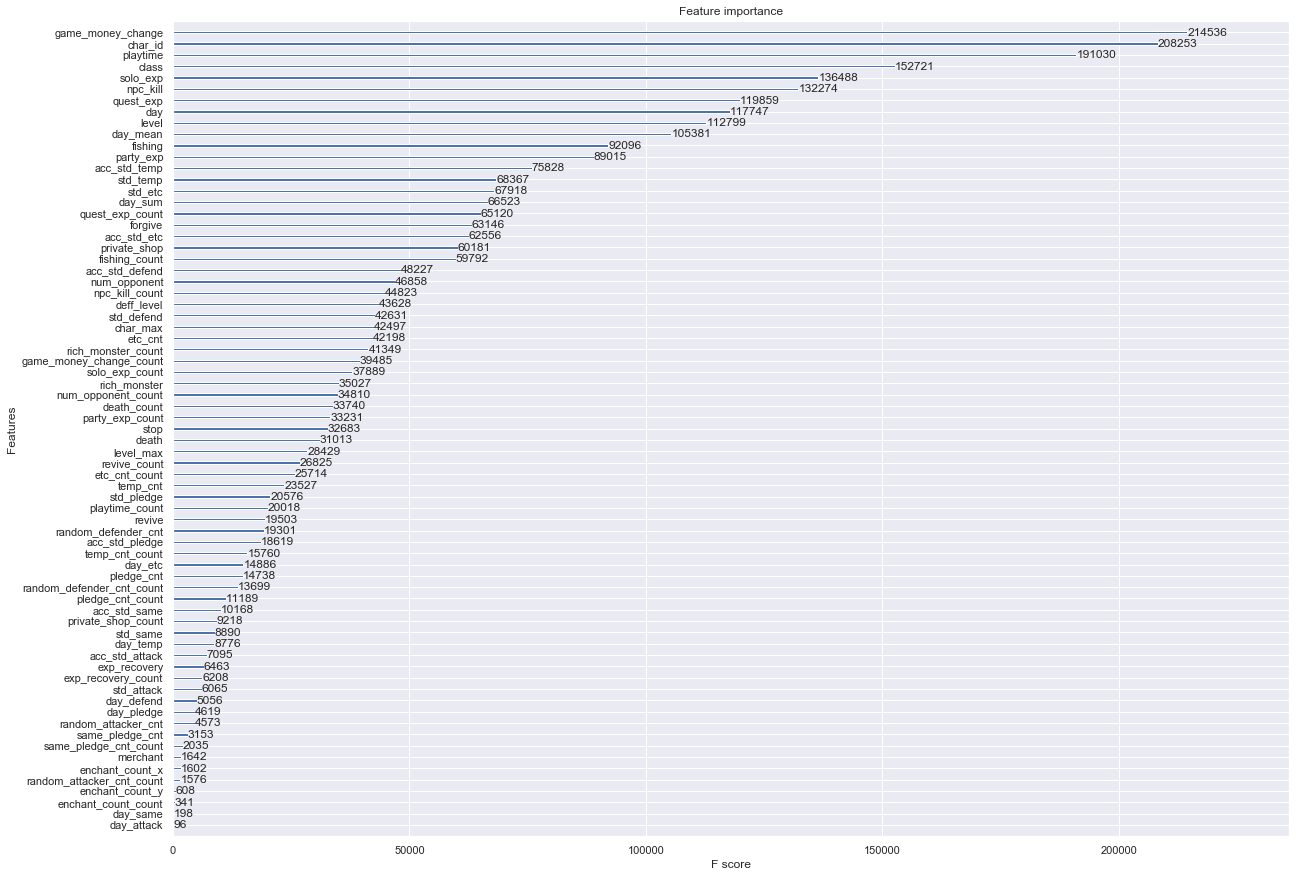

In [162]:
from xgboost import plot_importance
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))
plot_importance(xg_reg, ax=ax)
plt.show()

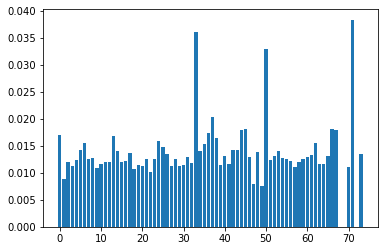

In [111]:
plt.bar(range(len(xg_reg.feature_importances_)), xg_reg.feature_importances_)
plt.show()

In [164]:
# save model to file
import pickle
pickle.dump(xg_reg, open("xg_survival1.pickle.dat", "wb"))


In [165]:
# load model from file
xg_survival1 = pickle.load(open("xg_survival1.pickle.dat", "rb"))

In [183]:
k = act_40000_best.drop(['acc_id'],axis=1)
y_pred = xg_survival1.predict(k)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

ValueError: feature_names mismatch: ['day', 'char_id', 'class', 'temp_cnt', 'private_shop', 'level', 'party_exp', 'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt', 'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill', 'solo_exp', 'quest_exp', 'rich_monster', 'death', 'revive', 'exp_recovery', 'fishing', 'game_money_change', 'enchant_count_x', 'forgive', 'enchant_count_y', 'pledge_cnt_count', 'random_attacker_cnt_count', 'random_defender_cnt_count', 'temp_cnt_count', 'same_pledge_cnt_count', 'etc_cnt_count', 'num_opponent_count', 'playtime_count', 'npc_kill_count', 'solo_exp_count', 'party_exp_count', 'quest_exp_count', 'rich_monster_count', 'death_count', 'revive_count', 'exp_recovery_count', 'fishing_count', 'private_shop_count', 'game_money_change_count', 'enchant_count_count', 'stop', 'merchant', 'day_pledge', 'day_attack', 'day_defend', 'day_temp', 'day_same', 'day_etc', 'std_pledge', 'std_attack', 'std_defend', 'std_temp', 'std_same', 'std_etc', 'acc_std_pledge', 'acc_std_attack', 'acc_std_defend', 'acc_std_temp', 'acc_std_same', 'acc_std_etc', 'deff_level', 'level_max', 'day_count', 'char_count', 'char_max', 'day_sum', 'day_28', 'day_mean'] ['class', 'temp_cnt', 'private_shop', 'level', 'party_exp', 'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt', 'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill', 'solo_exp', 'quest_exp', 'rich_monster', 'death', 'revive', 'exp_recovery', 'fishing', 'game_money_change', 'enchant_count_x', 'forgive', 'enchant_count_y', 'pledge_cnt_count', 'random_attacker_cnt_count', 'random_defender_cnt_count', 'temp_cnt_count', 'same_pledge_cnt_count', 'etc_cnt_count', 'num_opponent_count', 'playtime_count', 'npc_kill_count', 'solo_exp_count', 'party_exp_count', 'quest_exp_count', 'rich_monster_count', 'death_count', 'revive_count', 'exp_recovery_count', 'fishing_count', 'private_shop_count', 'game_money_change_count', 'enchant_count_count', 'stop', 'merchant', 'day_pledge', 'day_attack', 'day_defend', 'day_temp', 'day_same', 'day_etc', 'std_pledge', 'std_attack', 'std_defend', 'std_temp', 'std_same', 'std_etc', 'acc_std_pledge', 'acc_std_attack', 'acc_std_defend', 'acc_std_temp', 'acc_std_same', 'acc_std_etc', 'deff_level', 'level_max', 'day_count', 'char_count', 'char_max', 'day_sum', 'day_28']
expected day, day_mean, char_id in input data

In [177]:
y_pred.shape

(12000,)

In [168]:
pred_label = pd.concat([train_label[['acc_id','survival_time']],y_pred], axis=1 )

TypeError: cannot concatenate object of type "<class 'numpy.ndarray'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

In [170]:
pred_label = DataFrame(y_pred, columns=['pred_survival_time'])

In [174]:
pred_label2 = pd.concat([train_label[['acc_id','survival_time']],pred_label],axis=1)

In [175]:
pred_label2

,acc_id,survival_time,pred_survival_time
0,27835,64,64.0
1,12351,64,64.0
2,125437,55,64.0
3,104483,64,64.0
4,4704,20,64.0
5,3277,50,64.0
6,118874,64,1.0
7,7678,5,64.0
8,124997,46,64.0
9,116489,23,64.0


# dnn

In [51]:
act_40000_best.columns

Index(['acc_id', 'class', 'temp_cnt', 'private_shop', 'level', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'game_money_change', 'enchant_count_x',
       'forgive', 'enchant_count_y', 'pledge_cnt_count',
       'random_attacker_cnt_count', 'random_defender_cnt_count',
       'temp_cnt_count', 'same_pledge_cnt_count', 'etc_cnt_count',
       'num_opponent_count', 'playtime_count', 'npc_kill_count',
       'solo_exp_count', 'party_exp_count', 'quest_exp_count',
       'rich_monster_count', 'death_count', 'revive_count',
       'exp_recovery_count', 'fishing_count', 'private_shop_count',
       'game_money_change_count', 'enchant_count_count', 'stop', 'merchant',
       'day_pledge', 'day_attack', 'day_defend', 'day_temp', 'day_same',
       'day_etc', 'std_pledge', 'std_attack'

In [52]:
payment = train_payment.groupby(['acc_id']).sum().reset_index()

In [53]:
act_40000_best = pd.merge(act_40000_best, payment, on ='acc_id', how='outer').fillna(0)

In [54]:
act_40000_best.columns

Index(['acc_id', 'class', 'temp_cnt', 'private_shop', 'level', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'game_money_change', 'enchant_count_x',
       'forgive', 'enchant_count_y', 'pledge_cnt_count',
       'random_attacker_cnt_count', 'random_defender_cnt_count',
       'temp_cnt_count', 'same_pledge_cnt_count', 'etc_cnt_count',
       'num_opponent_count', 'playtime_count', 'npc_kill_count',
       'solo_exp_count', 'party_exp_count', 'quest_exp_count',
       'rich_monster_count', 'death_count', 'revive_count',
       'exp_recovery_count', 'fishing_count', 'private_shop_count',
       'game_money_change_count', 'enchant_count_count', 'stop', 'merchant',
       'day_pledge', 'day_attack', 'day_defend', 'day_temp', 'day_same',
       'day_etc', 'std_pledge', 'std_attack'

In [55]:
# 정규화
stop_count_acc = act_40000_best[['acc_id']]
stop_count_col = act_40000_best[['class', 'temp_cnt', 'private_shop', 'level', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'game_money_change', 'enchant_count_x',
       'forgive', 'enchant_count_y', 'pledge_cnt_count',
       'random_attacker_cnt_count', 'random_defender_cnt_count',
       'temp_cnt_count', 'same_pledge_cnt_count', 'etc_cnt_count',
       'num_opponent_count', 'playtime_count', 'npc_kill_count',
       'solo_exp_count', 'party_exp_count', 'quest_exp_count',
       'rich_monster_count', 'death_count', 'revive_count',
       'exp_recovery_count', 'fishing_count', 'private_shop_count',
       'game_money_change_count', 'enchant_count_count', 'stop', 'merchant',
       'day_pledge', 'day_attack', 'day_defend', 'day_temp', 'day_same',
       'day_etc', 'std_pledge', 'std_attack', 'std_defend', 'std_temp',
       'std_same', 'std_etc', 'acc_std_pledge', 'acc_std_attack',
       'acc_std_defend', 'acc_std_temp', 'acc_std_same', 'acc_std_etc',
       'deff_level', 'level_max', 'day_count', 'char_count', 'char_max',
       'day_sum','amount_spent']]


min1 = np.min(stop_count_col, 0) # 각 열마다 최소값 
max1 = np.max(stop_count_col, 0) # 각 열마다 최대값 
stop_count_col_pre = (stop_count_col-min1)/(max1-min1) # 정규화: (X-min) / (max - min)

# acc,day 데이터와 정규화된 데이터 합치기
data_final = pd.concat([stop_count_acc,stop_count_col_pre], axis=1)

In [56]:
from sklearn.decomposition import PCA
data_pca = data_final.drop(['acc_id'], axis=1)
pca = PCA(n_components=50)
train1 = pca.fit(data_pca).transform(data_pca)
sum(pca.explained_variance_ratio_)

0.9996124212361112

In [57]:
train_label = pd.read_csv('./train_label_add.csv')
total_spent = train_label[['acc_id','total_spent']].sort_values('acc_id').reset_index().drop(['index'],axis=1)
amount_spent = train_label[['acc_id','amount_spent']].sort_values('acc_id').reset_index().drop(['index'],axis=1)


In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train1, total_spent['total_spent'], test_size=0.3, random_state=42)
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape,  X_test.shape, y_train.shape, y_test.shape

((28000, 50), (12000, 50), (28000,), (12000,))

In [66]:
# total_spent
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras import optimizers


#  model 정의
model = Sequential()
model.add(Dense(128,activation='relu',input_shape=(50,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))

adam = optimizers.Adam(lr=0.0001)

model.compile(optimizer=adam, loss='mse', metrics=['acc']) 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               6528      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
__________

In [67]:
# callback
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min')

In [68]:
# fit model
model.fit(X_train, y_train, epochs=1000000, batch_size=128, validation_data=(X_test, y_test),
          callbacks=[early_stopping])

Train on 28000 samples, validate on 12000 samples
Epoch 1/1000000
28000/28000 [==============================] - 2s 88us/step - loss: 38.4307 - acc: 0.0843 - val_loss: 31.4262 - val_acc: 0.1633
Epoch 2/1000000
28000/28000 [==============================] - 2s 56us/step - loss: 31.3964 - acc: 0.1418 - val_loss: 30.1054 - val_acc: 0.1884
Epoch 3/1000000
28000/28000 [==============================] - 2s 57us/step - loss: 30.7611 - acc: 0.1601 - val_loss: 29.9400 - val_acc: 0.2190
Epoch 4/1000000
28000/28000 [==============================] - 2s 57us/step - loss: 30.4575 - acc: 0.1785 - val_loss: 29.6876 - val_acc: 0.2368
Epoch 5/1000000
28000/28000 [==============================] - 2s 57us/step - loss: 30.0607 - acc: 0.1820 - val_loss: 29.4964 - val_acc: 0.2432
Epoch 6/1000000
28000/28000 [==============================] - 2s 58us/step - loss: 29.9935 - acc: 0.1948 - val_loss: 29.3347 - val_acc: 0.2171
Epoch 7/1000000
28000/28000 [==============================] - 2s 58us/step - loss: 29

28000/28000 [==============================] - 2s 69us/step - loss: 21.7872 - acc: 0.1994 - val_loss: 33.0694 - val_acc: 0.2204
Epoch 58/1000000
28000/28000 [==============================] - 2s 70us/step - loss: 21.5184 - acc: 0.2079 - val_loss: 32.3249 - val_acc: 0.1968
Epoch 59/1000000
28000/28000 [==============================] - 2s 70us/step - loss: 21.4277 - acc: 0.2005 - val_loss: 32.3053 - val_acc: 0.2182
Epoch 60/1000000
28000/28000 [==============================] - 2s 69us/step - loss: 21.0761 - acc: 0.2043 - val_loss: 32.8311 - val_acc: 0.2159
Epoch 61/1000000
28000/28000 [==============================] - 2s 71us/step - loss: 21.0006 - acc: 0.2116 - val_loss: 32.5906 - val_acc: 0.2231
Epoch 62/1000000
28000/28000 [==============================] - 2s 72us/step - loss: 20.7677 - acc: 0.2100 - val_loss: 32.6646 - val_acc: 0.2128
Epoch 63/1000000
28000/28000 [==============================] - 2s 70us/step - loss: 20.4821 - acc: 0.2060 - val_loss: 33.0795 - val_acc: 0.2042
Ep

In [70]:
from keras.models import load_model

model.save('./DNN_model_total1.h5')

In [97]:
dnn_total = load_model('./DNN_model_total1.h5')
t_pred = dnn_total.predict(train1)

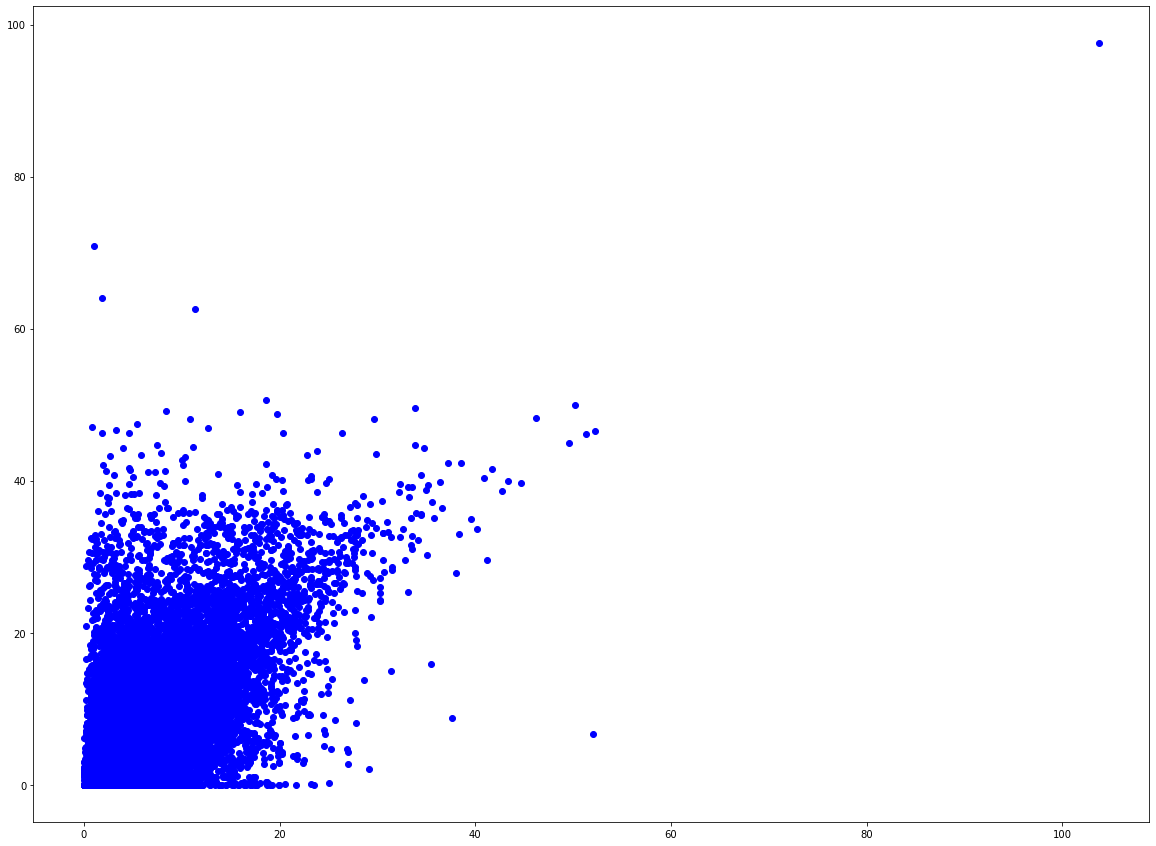

In [98]:
b = train_label[['acc_id','total_spent']].sort_values('acc_id')
b['total_pred'] = t_pred
plt.figure(figsize=(20,15))
plt.plot(b['total_pred'], b['total_spent'], 'bo')

# 랜덤포레스트

In [71]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
rnd_clf = RandomForestRegressor(n_estimators=700,random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred))

ValueError: continuous is not supported

#### 랜포 총결제량 예측

In [72]:
# save model to file
import pickle
pickle.dump(rnd_clf, open("rnd_total_spent1.pickle.dat", "wb"))

In [73]:
# load model from file
rnd_amount_spent1 = pickle.load(open("rnd_total_spent1.pickle.dat", "rb"))

In [75]:
# total spent 예측
data_for_total = train1
total_pred = rnd_amount_spent1.predict(data_for_total)

In [79]:
a = train_label[['acc_id','total_spent']].sort_values('acc_id')

In [83]:
a['total_pred'] = total_pred

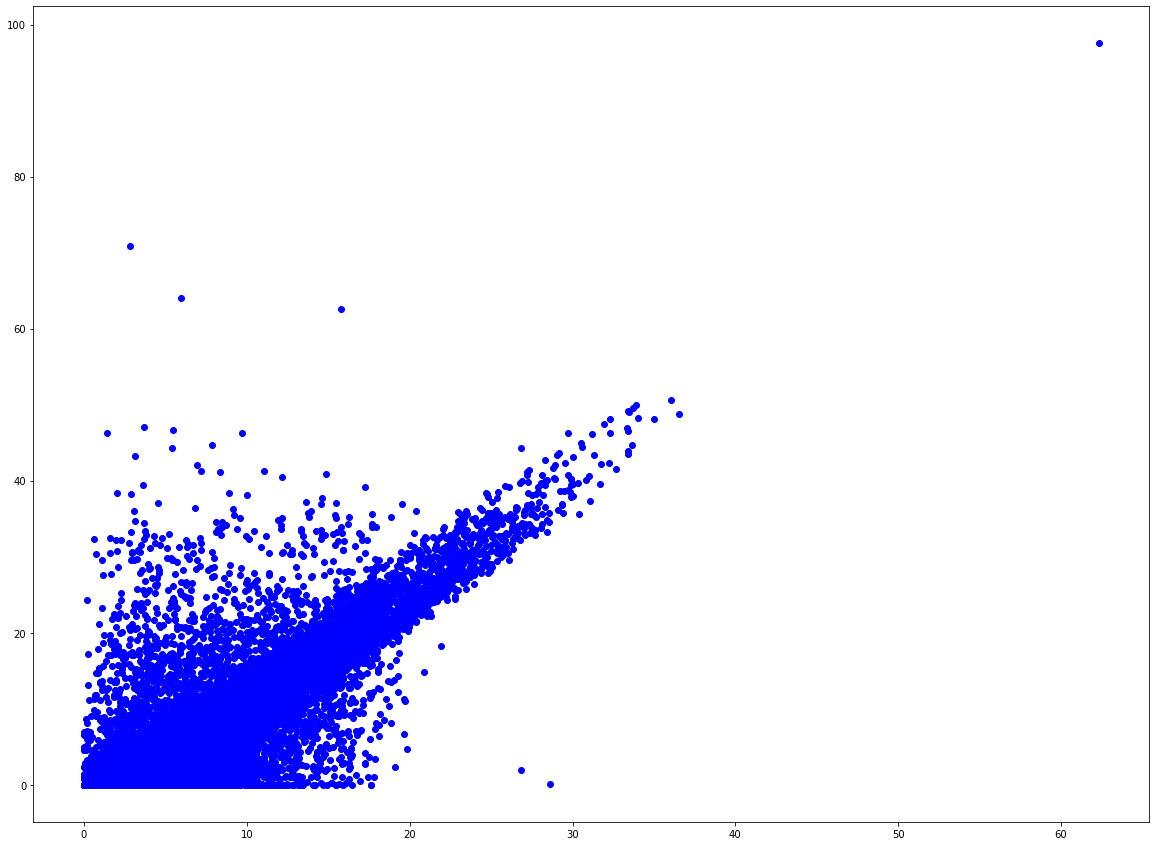

In [86]:
plt.figure(figsize=(20,15))
plt.plot(a['total_pred'], a['total_spent'], 'bo')

In [87]:
pred_label_load = pd.read_csv('./pred_label_train1.csv')

In [88]:
# xgb 생존기간이랑 연산해서 기대이익 구해보기

In [89]:
pred_label_load['total_spent'] = total_pred

In [90]:
pred_label_load['amount_spent'] = pred_label_load['total_spent'] / pred_label_load['survival_time']

In [91]:
pred_label_load = pred_label_load.drop('total_spent',axis=1)

In [93]:
pred_label_load.to_csv('./xgb_rnd_total1.csv', index=False)

#### 랜포 일평균결제량 예측

In [ ]:
# save model to file
import pickle
pickle.dump(rnd_clf, open("rnd_amount_spent1.pickle.dat", "wb"))

In [269]:
# load model from file
rnd_amount_spent1 = pickle.load(open("rnd_amount_spent1.pickle.dat", "rb"))

In [318]:
# amount spent 예측
data_for_spent = data_final.drop(['acc_id'],axis=1)
spent_pred = rnd_amount_spent1.predict(data_for_spent)

#### 랜포 생존기간 예측

In [319]:
# survivla time 예측
data_for_survival = act_40000_best.drop(['acc_id'],axis=1)
survival_pred = xg_survival1.predict(data_for_survival)

In [321]:
survival_pred_df = DataFrame(survival_pred, columns=['survival_time'])
survival_pred_df

,survival_time
0,64
1,64
2,64
3,64
4,64
5,64
6,64
7,64
8,3
9,64


In [322]:
spent_pred_df = DataFrame(spent_pred, columns=['amount_spent'])
spent_pred_df

,amount_spent
0,5.159243e-04
1,6.570624e-01
2,4.879755e-02
3,7.348677e-02
4,1.123935e-01
5,1.718225e-01
6,1.223562e-02
7,2.660420e-01
8,1.422244e-06
9,3.055788e-01


In [324]:
pred_concat = pd.concat([survival_pred_df, spent_pred_df], axis=1)
pred_concat

,survival_time,amount_spent
0,64,5.159243e-04
1,64,6.570624e-01
2,64,4.879755e-02
3,64,7.348677e-02
4,64,1.123935e-01
5,64,1.718225e-01
6,64,1.223562e-02
7,64,2.660420e-01
8,3,1.422244e-06
9,64,3.055788e-01


In [330]:
acc =train_label[['acc_id']].sort_values(['acc_id']).reset_index().drop('index',axis=1)
acc

,acc_id
0,2
1,5
2,8
3,17
4,20
5,21
6,31
7,38
8,41
9,43


In [335]:

pred_label = pd.concat([acc, pred_concat], axis=1).reset_index().drop('index',axis=1)
pred_label

,acc_id,survival_time,amount_spent
0,2,64,5.159243e-04
1,5,64,6.570624e-01
2,8,64,4.879755e-02
3,17,64,7.348677e-02
4,20,64,1.123935e-01
5,21,64,1.718225e-01
6,31,64,1.223562e-02
7,38,64,2.660420e-01
8,41,3,1.422244e-06
9,43,64,3.055788e-01


In [336]:
#survival_pred_df = DataFrame(survival_pred, columns=['survival_time'])
#spent_pred_df = DataFrame(spent_pred, columns=['amount_spent'])
#pred_concat = pd.concat([,survival_pred_df, spent_pred_df], axis=1)
#pred_label = pd.concat([train_label[['acc_id']], pred_concat], axis=1)
pred_label.to_csv('pred_label_train1.csv')

In [337]:
pred_label_load = pd.read_csv('./pred_label_train1.csv')

In [94]:
from score_function import score_function

In [342]:
score = score_function('./pred_label_train1.csv', './train_label.csv')

43292.273791459054


In [95]:
score = score_function('./xgb_dnn_total1.csv', './train_label.csv')

54410.056972604245


# 중간 결론

제가 1,2주차에 만들었던 특성들을 추가하여 생존기간은 xgb로, rnd로 일평균과 총결제량을, dnn으로 총결제량을 예측했습니다. dnn이 loss 값이 lstm보다 낮아서 dnn을 썼습니다.

발견한 사항
1. amount_spent가 아니라 total_spent로 하는 게 더 좋습니다. 점수가 43000점(xgb, rnd)에서 54000(xgb, rnd)점으로 뛰었습니다.

2. dnn과 rnd의 총결제량 예측 정도를 비교해본 결과 rnd가 더 좋았습니다. 위에 그래프를 보시면 알 수 있습니다. 

3. train 데이터 대상으로는 점수가 10000점이나 올랐지만, 빅콘에 제출한 결과 본래 점수보다 조금 낮은 점수가 나왔습니다.(제가 총결제량 예측할 때 pca를 했는데, 그래서 그럴까요?? test1,2랑 데이터가 다르니까 pca 결과값이 다르게 나오더라고요..)

4. 어찌되었던 만점 향상했는데 test 점수는 더 떨어졌다는 건 게임 이벤트에 영향을 받지 않도록 하게 중요하다는 의미 같습니다. 